Даны кусочки изображения, надо склеить пазл в исходную картинку. 

Условия:
* Картинки имеют друг с другом пересечение
* На картинках есть шум, т.е. их пересечения не совпадают попиксельно
* Ширина наложения картинок по х одинакова (и по у тоже)
* После разрезки кусочки пазлов не были повернуты или отражены

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from time import time
from datetime import timedelta

In [2]:
pip install opencv-contrib-python

Загрузим пикчи

In [3]:
puzzles = [('su_fighter',8), ('china',35), ('home',150), ('dora',25), ('joker',40), ('astro',12), ('city4k',450)]
chosen = 3

imgs = []
imgs_gray = []

for i in range(puzzles[chosen][1]):
    file_name = f'puzzle/{puzzles[chosen][0]}_shuffle/{i}.jpg'
    
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs.append(img.copy())

    img_gray = cv2.imread(file_name, 0)
    imgs_gray.append(img_gray.copy())
    
piece_size = np.array(imgs[0].shape[:2])

Определим ширину наложения при помощи ключевых точек

In [4]:
def find_shift(kp1, kp2, matches, axis):
    ort_axis = (axis+1)%2
    diffs = []
    for idx in range(len(matches)):
        if abs(kp1[axis][idx] - kp2[axis][idx]) < 0.5: 
            diffs.append(kp1[ort_axis][idx] - kp2[ort_axis][idx])
    
    if len(diffs) >= 2 and abs(np.max(diffs) - np.min(diffs)) < 1:
        return np.median(diffs)
    return None

def find_shift_and_axis(img1, kp1, desc1, img2, kp2, desc2, flann):
    if (desc1 is None or len(desc1) < 2) or (desc2 is None or len(desc2) < 2):
        return None, None
    
    matches = flann.knnMatch(desc1, desc2, k=2)
    
    ratio_thresh = 0.7
    good_matches = np.array([])
    kp1_coords = np.array([[],[]])
    kp2_coords = np.array([[],[]])
    
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches = np.append(good_matches, m)
            p1 = kp1[m.queryIdx].pt
            kp1_coords = np.append(kp1_coords, [[p1[0]], [p1[1]]], axis=1)
            p2 = kp2[m.trainIdx].pt
            kp2_coords = np.append(kp2_coords, [[p2[0]], [p2[1]]], axis=1)
    
    axis = 0
    shift = find_shift(kp1_coords, kp2_coords, good_matches, axis)
    if shift is None:
        axis = 1
        shift = find_shift(kp1_coords, kp2_coords, good_matches, axis)
    return shift, axis

In [5]:
hyp_params = dict(
    nfeatures = 100,
    nOctaveLayers = 3,
    contrastThreshold = 0.03,
    edgeThreshold = 10,
    sigma = 1.6
)

detector = cv2.xfeatures2d.SIFT_create(**hyp_params)

In [6]:
FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

In [7]:
shift = np.array([None, None])

t1 = time()

keypoints = [None] * len(imgs)
descs = [None] * len(imgs)
for idx, img in enumerate(imgs):
    keypoints[idx], descs[idx] = detector.detectAndCompute(img, None)

for idx1, img1 in enumerate(imgs):
    for idx2, img2 in enumerate(imgs):
        if idx2 > idx1:
            cur_shift, axis = find_shift_and_axis(
                img1, keypoints[idx1], descs[idx1], 
                img2, keypoints[idx2], descs[idx2], 
                flann
            )
            if cur_shift and axis == 0 and shift[0] is None:
                shift[0] = round(abs(cur_shift))
            if cur_shift and axis == 1 and shift[1] is None:
                shift[1] = round(abs(cur_shift))
            if np.all(shift != None):
                break
    if np.all(shift != None):
        break
        
t2 = time()

overlap = piece_size - shift

print(timedelta(seconds=t2-t1))
print('shift   =', shift)
print('overlap =', overlap)

0:00:01.223911
shift   = [140 250]
overlap = [20 30]


Если размеры картинок и ширина наложение - четные, можно сжать в два раза по обеим осям

In [8]:
compress_factor = 1

if np.all(piece_size % 2 == 0) and np.all(overlap % 2 == 0):
    compress_factor = 0.5
    
    overlap = (overlap * compress_factor).astype(np.int32)
    
    for idx in range(len(imgs_gray)):
        imgs_gray[idx] = cv2.resize(imgs_gray[idx], (0, 0), fx=compress_factor, fy=compress_factor)
        
    print("Compressed")

Compressed


Найдем пересекающие кусочки с помощью кросс корреляции и построим граф (вершина - картинка, ребро - наличие пересечения)

In [9]:
def overlap_cross_corr(img1, img2, axis, overlap):
    if axis == 0:
        slice1 = img1[-overlap:, :]
        slice2 = img2[:overlap, :]
        percent_black1 = np.count_nonzero(slice1 == 0) / (slice1.shape[0] * slice1.shape[1])
        percent_black2 = np.count_nonzero(slice2 == 0) / (slice2.shape[0] * slice2.shape[1])
        if percent_black1 < 0.8 and percent_black2 < 0.8:
            return cv2.matchTemplate(slice1, slice2, cv2.TM_CCOEFF_NORMED)[0][0]
    if axis == 1:
        slice1 = img1[:, -overlap:]
        slice2 = img2[:, :overlap]
        percent_black1 = np.count_nonzero(slice1 == 0) / (slice1.shape[0] * slice1.shape[1])
        percent_black2 = np.count_nonzero(slice2 == 0) / (slice2.shape[0] * slice2.shape[1])
        if percent_black1 < 0.8 and percent_black2 < 0.8:
            return cv2.matchTemplate(slice1, slice2, cv2.TM_CCOEFF_NORMED)[0][0]
    return 0

In [10]:
graph = [[] for _ in range(len(imgs))]
threshold = 0.95

t1 = time()
for idx1, img1 in enumerate(imgs_gray):
    close_imgs = []
    
    for idx2, img2 in enumerate(imgs_gray):
        a = np.array([
            overlap_cross_corr(img1, img2, 0, overlap[0]), 
            overlap_cross_corr(img2, img1, 0, overlap[0]),
            overlap_cross_corr(img1, img2, 1, overlap[1]), 
            overlap_cross_corr(img2, img1, 1, overlap[1])
        ])
        max_idx = np.argmax(a)
        if a[max_idx] > threshold:
            if max_idx == 0: close_imgs.append((a[max_idx], idx2, 'd'))
            elif max_idx == 1: close_imgs.append((a[max_idx], idx2, 'u'))
            elif max_idx == 2: close_imgs.append((a[max_idx], idx2, 'r'))
            else: close_imgs.append((a[max_idx], idx2, 'l'))
            
    close_imgs.sort(reverse=True)
    directions = set()
    for _, idx2, direction in close_imgs:
        if direction not in directions:
            directions.add(direction)
            graph[idx1].append((idx2, direction))

t2 = time()
print(timedelta(seconds=t2-t1))

0:00:00.416098


Восстаноим исходную картинчку по графу, обойдя чего через DFS

In [11]:
def place_on_xy(v, graph, positions):
    for u, direction in graph[v]:
        if u not in positions:
            px, py = positions[v]
            if direction == 'u': px -= 1
            elif direction == 'd': px += 1
            elif direction == 'r': py += 1
            else: py -= 1
            positions[u] = (px, py)
            
            place_on_xy(u, graph, positions)
            
def find_rows_and_cols_count(positions):
    top_right = np.array(max(positions.values()))
    left_bottom = np.array(min(positions.values()))
    return top_right - left_bottom + 1

def move_to_first_quarter(positions):
    left_bottom = min(positions.values())
    for i in positions:
        positions[i] = (positions[i][0] - left_bottom[0], positions[i][1] - left_bottom[1])
        
def print_accuracy(grid_size, positions, graph):
    grid = np.zeros(grid_size, dtype=np.int32)
    for idx, (x, y) in positions.items():
        grid[x, y] = idx
    correct_graph = [[] for _ in range(len(graph))]
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            if x > 0:
                correct_graph[grid[x,y]].append((grid[x-1,y], 'u'))
            if x < grid_size[0] - 1:
                correct_graph[grid[x,y]].append((grid[x+1,y], 'd'))
            if y > 0:
                correct_graph[grid[x,y]].append((grid[x,y-1], 'l'))
            if y < grid_size[1] - 1:
                correct_graph[grid[x,y]].append((grid[x,y+1], 'r'))
    
    true, false, missed = 0, 0, 0
    for idx in range(len(graph)):
        intersect_size = len(set(graph[idx]).intersection(correct_graph[idx]))
        true += intersect_size
        false += len(graph[idx]) - intersect_size
        missed += len(correct_graph[idx]) - intersect_size
        
    cnt = true + false + missed
    print(f'Correct:   {true}/{cnt}   ' + '%.3f' % (true/cnt))
    print(f'Incorrect: {false}/{cnt}   ' + '%.3f' % (false/cnt))
    print(f'Missed:    {missed}/{cnt}   ' + '%.3f' % (missed/cnt))

In [12]:
positions = {0 : (0,0)}
place_on_xy(0, graph, positions)

size = find_rows_and_cols_count(positions)
collected_img_size = shift * (size - 1) + piece_size
print('Collected image size:', collected_img_size)

move_to_first_quarter(positions)

collected_img = np.zeros((*collected_img_size, 3), dtype=np.uint8)
for idx, pos in positions.items():
    p = shift * np.array(pos)
    collected_img[p[0]:p[0] + piece_size[0], p[1]:p[1] + piece_size[1]] = imgs[idx]

Collected image size: [720 1280]


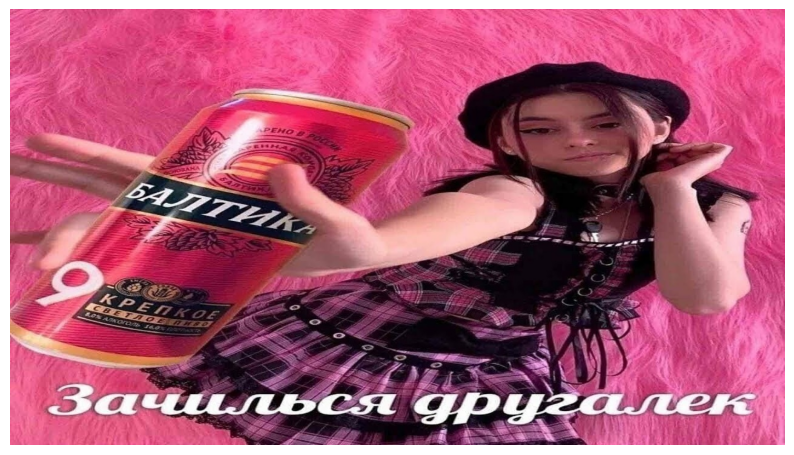

In [13]:
plt.figure(figsize=(10,13))

plt.imshow(collected_img, cmap='gray')
plt.axis('off')

plt.show()

In [14]:
print_accuracy(size, positions, graph)

Correct:   80/80   1.000
Incorrect: 0/80   0.000
Missed:    0/80   0.000
